- csvのデータ一覧
id 顧客ID（インデックスとして使用）  
loan_amnt 借入総額  
term 返済期間  
interest_rate 金利  
grade グレード  
employment_length 勤続年数  
purpose 借入の目的  
credit_score 信用スコア  
application_type 借入時の申請方式  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# pip install は !pip... で可

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.replace({'Individual': 0, 'Joint App': 1}, inplace=True)
train.replace({'FullyPaid': 0, 'ChargedOff': 1}, inplace=True)
train = pd.get_dummies(train, prefix='', prefix_sep='', columns=['term', 'grade', 'purpose'])

In [5]:
test.replace({'Individual': 0, 'Joint App': 1}, inplace=True)
test = pd.get_dummies(test, prefix='', prefix_sep='', columns=['term', 'grade', 'purpose'])

In [6]:
train['moving'] = 0
test['F3'] = 0
test['F5'] = 0

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train, train['loan_status'], test_size=0.3, random_state=0, stratify=train['loan_status'])

In [8]:
X_train.drop(columns=['loan_amnt', 'employment_length', 'credit_score', 'loan_status'], inplace=True)
X_valid.drop(columns=['loan_amnt', 'employment_length', 'credit_score', 'loan_status'], inplace=True)
y_train.drop(columns=['loan_amnt', 'employment_length', 'credit_score'], inplace=True)
y_valid.drop(columns=['loan_amnt', 'employment_length', 'credit_score'], inplace=True)
categorical_feature = ['interest_rate', 'application_type', '3 years', '5 years', 'A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F3', 'F5', 'car', 'credit_card', 'debt_consolidation', 'home_improvement', 'house', 'major_purchase', 'medical', 'other', 'small_business', 'moving']

C:\Users\randy\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
test.drop(columns=['loan_amnt', 'employment_length', 'credit_score'], inplace=True)

In [10]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_feature)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_feature)

param = {
    'objective': 'binary',
        'metric': 'binary_error'
        }

model = lgb.train(param, lgb_train, valid_sets=[lgb_train, lgb_eval], verbose_eval=10, num_boost_round=1000, early_stopping_rounds=100)

y_pred = model.predict(test, num_iteration=model.best_iteration)

C:\Users\randy\Anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29649, number of negative: 139856
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 169505, number of used features: 38


C:\Users\randy\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\randy\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174915 -> initscore=-1.551185
[LightGBM] [Info] Start training from score -1.551185
Training until validation scores don't improve for 100 rounds
[10]	training's binary_error: 0.1716	valid_1's binary_error: 0.171726
[20]	training's binary_error: 0.168137	valid_1's binary_error: 0.168959
[30]	training's binary_error: 0.167641	valid_1's binary_error: 0.168766
[40]	training's binary_error: 0.167529	valid_1's binary_error: 0.168931
[50]	training's binary_error: 0.167275	valid_1's binary_error: 0.168683
[60]	training's binary_error: 0.167181	valid_1's binary_error: 0.168697
[70]	training's binary_error: 0.166992	valid_1's binary_error: 0.168628
[80]	training's binary_error: 0.16688	valid_1's binary_error: 0.168573
[90]	training's binary_error: 0.166815	valid_1's binary_error: 0.168697
[100]	training's binary_error: 0.166697	valid_1's binary_error: 0.168725
[110]	

In [23]:
X_pred = model.predict(X_valid, num_iteration=model.best_iteration)
X_pred = (X_pred > 0.18325).astype(int)
f1_score(y_valid, X_pred)

0.38332446008194254

In [27]:
X_pred = model.predict(X_valid, num_iteration=model.best_iteration)
X_pred = (X_pred > 0.183255).astype(int)
f1_score(y_valid, X_pred)

0.38332446008194254

In [34]:
# train_pred = model.predict(X_train, num_iteration=model.best_iteration)
# train_pred = (train_pred > 0.5).astype(int)
# f1_score(y_train, train_pred)

In [28]:
y_pred = (y_pred > 0.18325).astype(int)
Id = test.id.astype(int)
my_solution = pd.DataFrame(y_pred, Id, columns=['loan_status'])
my_solution.to_csv("my_prediction_data.csv", header=False)

In [29]:
my_solution.head()

,loan_status
id,
242150,0
242151,0
242152,0
242153,0
242154,0


In [30]:
df = my_solution[my_solution['loan_status'] == 1]

In [31]:
len(df)

5908

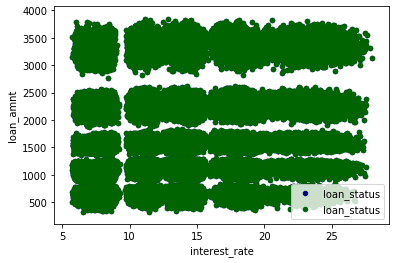

In [16]:
ax = train.plot(kind='scatter', x='interest_rate', y='loan_amnt', color='DarkBlue', label='loan_status')
train.plot(kind='scatter', x='interest_rate', y='loan_amnt', color='DarkGreen', label='loan_status', ax=ax)

In [25]:
# 「train」の目的変数と説明変数の値を取得
target = train["loan_status"].values
features_one = train[["loan_amnt", "term", "interest_rate", "employment_length", 'grade', 'debt_consolidation', 'credit_card', 'medical', \
                          'home_improvement', 'car', 'major_purchase', 'small_business', 'house', 'moving', 'other']].values

# 決定木の作成
my_tree_one = tree.DecisionTreeClassifier()
my_tree_one = my_tree_one.fit(features_one, target) # <- term: 3 year = ValueError

# 「test」の説明変数の値を取得
test_features = test[["loan_amnt", "term", "interest_rate", "employment_length", 'grade', 'debt_consolidation', 'credit_card', 'medical', \
                          'home_improvement', 'car', 'major_purchase', 'small_business', 'house', 'moving', 'other']].values

# 「test」の説明変数を使って「my_tree_one」のモデルで予測
my_prediction = my_tree_one.predict(test_features)

# PassengerIdを取得
Id = test.id.astype(int)
# Id.rename(inplace=True)
# Id = Id.value

# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
my_solution = pd.DataFrame(my_prediction, Id, columns=['loan_status'])

my_solution.replace({'FullyPaid': 0, 'ChargedOff': 1}, inplace=True)

# my_tree_one.csvとして書き出し
my_solution.to_csv("my_prediction_data.csv", header=False)
# to_csv header=False で行名を削除してcsv化

- "loan_amnt", "term", "interest_rate", "employment_length" の4項目で 0.24929点

↑の項目で学習方法をLigthGBLに変更して0.135点

- "loan_amnt", "term", "interest_rate", "employment_length", 'credit_score' の5項目で 0.24759点

- "loan_amnt", "term", "interest_rate", "employment_length", 'purpose' の5項目で 0.2510点

- "loan_amnt", "term", "interest_rate", 'purpose' の4項目で 0.24931点

- "loan_amnt", "term", "interest_rate", "employment_length", 'grade'の４項目で0.2639点

- "loan_amnt", "term", "interest_rate", "employment_length", 'grade', 'debt_consolidation', 'credit_card', 'medical', \
                          'home_improvement', 'car', 'major_purchase', 'small_business', 'house', 'moving'の１４項目で0.2706点

↑gradeを一つずつにわけGBLで学習0.1207267点

- "loan_amnt", "term", "interest_rate", "employment_length", 'grade', 'debt_consolidation', 'credit_card', 'medical', \
                          'home_improvement', 'car', 'major_purchase', 'small_business', 'house', 'moving', 'other'の１５項目で0.2677点

- categorical_feature = ['interest_rate', 'application_type', '3 years', '5 years', 'A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F3', 'F5', 'car', 'credit_card', 'debt_consolidation', 'home_improvement', 'house', 'major_purchase', 'medical', 'other', 'small_business']でLigthGBL閾値を0.2にして0.329点